# Dataset Evaluation Results Visualization

This notebook visualizes the results from the dataset evaluation script, comparing:
1. Detection bounding boxes (predicted vs ground truth)
2. Viewpoint classifications with confidence scores
3. Performance statistics and error analysis
4. Individual image results with overlays

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import seaborn as sns
from typing import Dict, List, Tuple
import pandas as pd

# Import analysis modules
from src.data.cvat_loader import CVATLoader
from src.models.dinov2_extractor import DINOv2PatchExtractor, aggregate_depth_to_patches
from src.utils.analysis_utils import load_analysis_model
from src.utils.config import load_config
from viewpoint_3d import estimate_viewpoint_with_axis_fitting

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## Load Evaluation Results

In [ ]:
# Configuration - UPDATE THESE PATHS
EVALUATION_DIR = Path('outputs/evaluation')  # Update to your evaluation results directory
RESULTS_FILE = EVALUATION_DIR / 'detailed_results.json'
STATS_FILE = EVALUATION_DIR / 'statistics.json'
CONFIG_FILE = Path('config.yaml')  # Configuration for loading models

# Load evaluation results
with open(RESULTS_FILE, 'r') as f:
    results = json.load(f)
    
with open(STATS_FILE, 'r') as f:
    stats = json.load(f)

# Load configuration for detailed analysis
config = load_config(CONFIG_FILE)
    
print(f"Loaded {len(results)} evaluation results")
print(f"Total images evaluated: {stats['overall']['total_images']}")
print(f"Mean detection IoU: {stats['detection']['mean_iou']:.3f}")
print(f"Viewpoint accuracy: {stats['viewpoint']['accuracy']:.3f}")

## Detection Performance Analysis

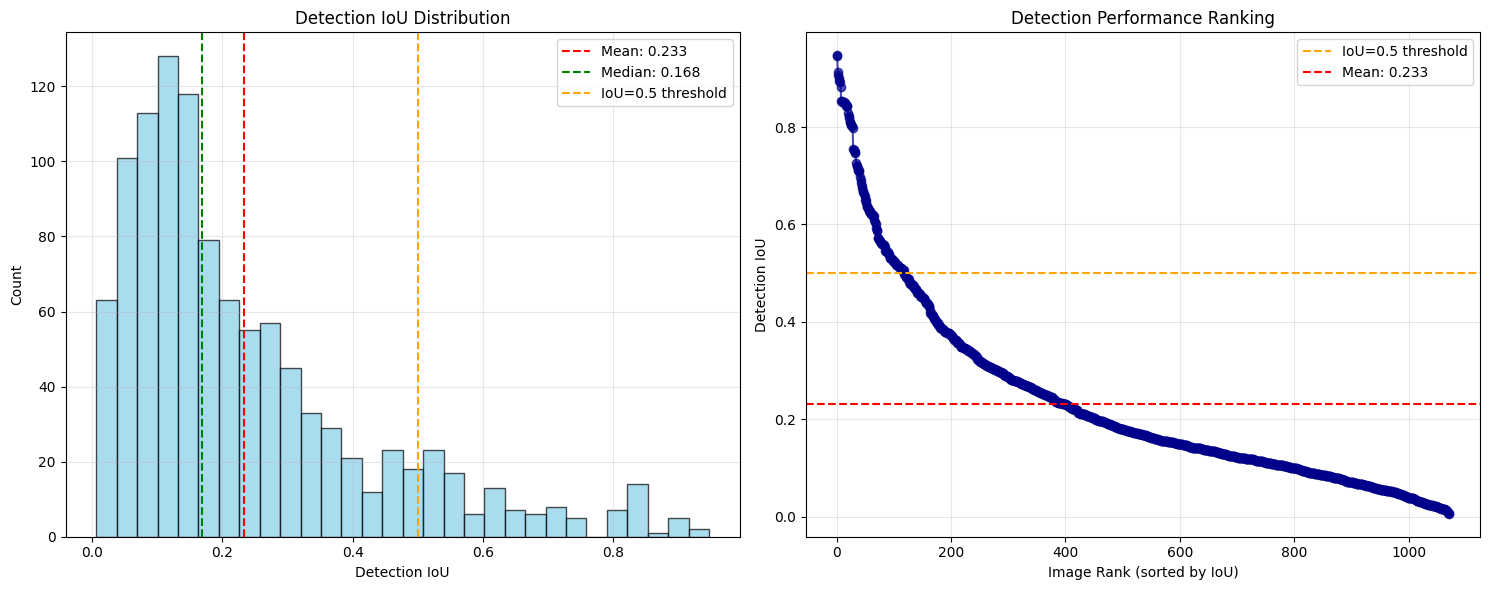


Detection Statistics:
  High IoU (>0.5): 118/1072 (11.0%)
  Mean IoU: 0.233
  Median IoU: 0.168
  Std IoU: 0.191
  Min IoU: 0.006
  Max IoU: 0.947


In [3]:
# Detection IoU analysis
ious = [r['detection_iou'] for r in results if r['detection_iou'] is not None]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# IoU distribution
ax1.hist(ious, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
ax1.axvline(x=np.mean(ious), color='red', linestyle='--', label=f'Mean: {np.mean(ious):.3f}')
ax1.axvline(x=np.median(ious), color='green', linestyle='--', label=f'Median: {np.median(ious):.3f}')
ax1.axvline(x=0.5, color='orange', linestyle='--', label='IoU=0.5 threshold')
ax1.set_xlabel('Detection IoU')
ax1.set_ylabel('Count')
ax1.set_title('Detection IoU Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# IoU vs Image Index (temporal analysis)
ax2.plot(range(len(ious)), sorted(ious, reverse=True), 'o-', alpha=0.7, color='darkblue')
ax2.axhline(y=0.5, color='orange', linestyle='--', label='IoU=0.5 threshold')
ax2.axhline(y=np.mean(ious), color='red', linestyle='--', label=f'Mean: {np.mean(ious):.3f}')
ax2.set_xlabel('Image Rank (sorted by IoU)')
ax2.set_ylabel('Detection IoU')
ax2.set_title('Detection Performance Ranking')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detection statistics
high_iou_count = sum(1 for iou in ious if iou > 0.5)
print(f"\nDetection Statistics:")
print(f"  High IoU (>0.5): {high_iou_count}/{len(ious)} ({high_iou_count/len(ious)*100:.1f}%)")
print(f"  Mean IoU: {np.mean(ious):.3f}")
print(f"  Median IoU: {np.median(ious):.3f}")
print(f"  Std IoU: {np.std(ious):.3f}")
print(f"  Min IoU: {np.min(ious):.3f}")
print(f"  Max IoU: {np.max(ious):.3f}")

## Viewpoint Classification Analysis

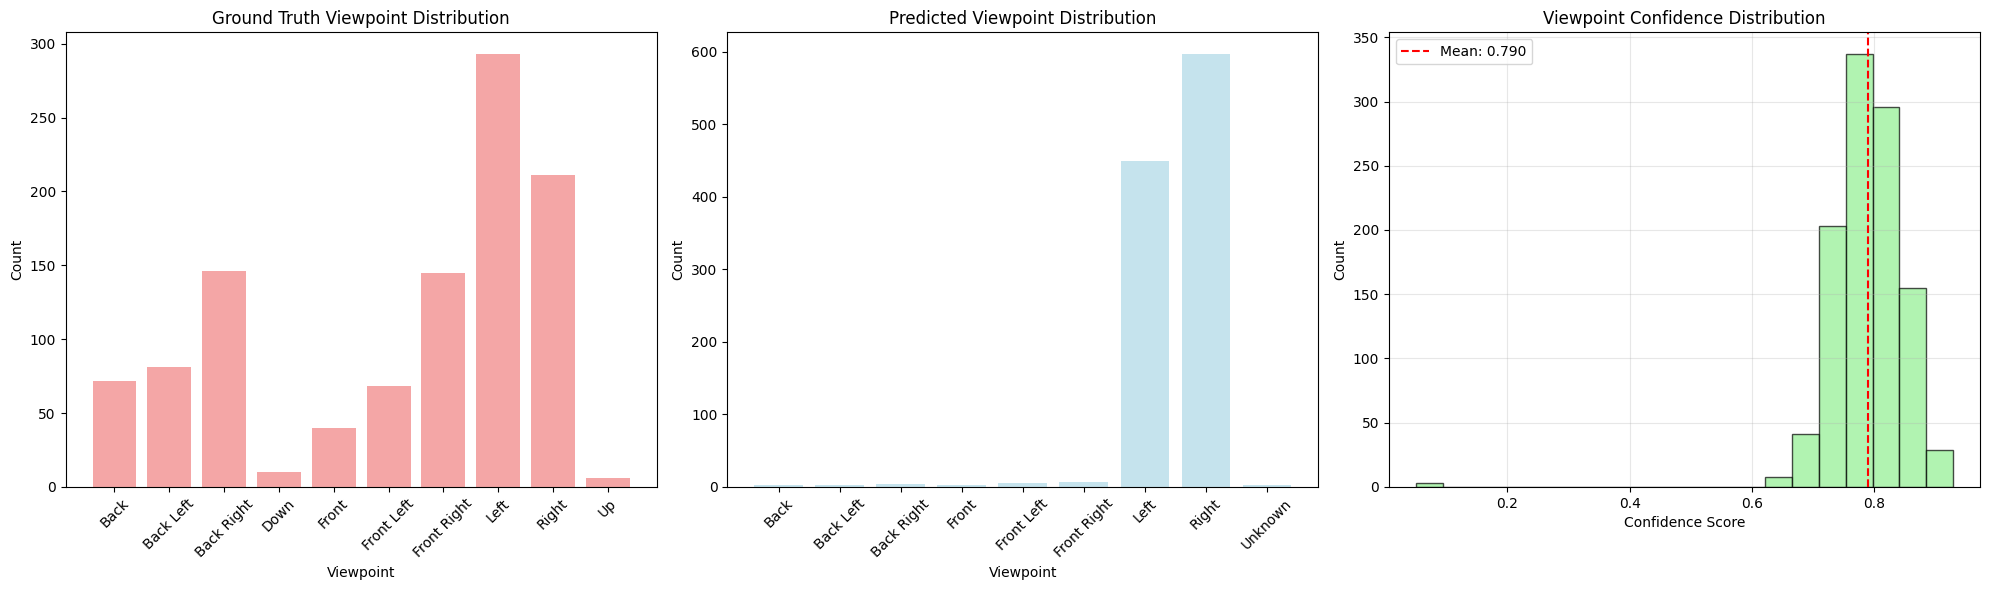


Per-Viewpoint Accuracy:
  Back: 1/72 (0.014)
  Back Left: 0/81 (0.000)
  Back Right: 0/146 (0.000)
  Down: 0/10 (0.000)
  Front: 2/40 (0.050)
  Front Left: 1/68 (0.015)
  Front Right: 4/145 (0.028)
  Left: 243/293 (0.829)
  Right: 201/211 (0.953)
  Up: 0/6 (0.000)


In [4]:
# Extract viewpoint data
gt_viewpoints = [r['gt_viewpoint'] for r in results if r['gt_viewpoint'] != 'Unknown']
pred_viewpoints = [r['predicted_viewpoint'] for r in results if r['gt_viewpoint'] != 'Unknown']
confidences = [r['viewpoint_confidence'] for r in results if r['gt_viewpoint'] != 'Unknown']

# Viewpoint distribution comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Ground truth distribution
gt_unique, gt_counts = np.unique(gt_viewpoints, return_counts=True)
ax1.bar(gt_unique, gt_counts, alpha=0.7, color='lightcoral')
ax1.set_xlabel('Viewpoint')
ax1.set_ylabel('Count')
ax1.set_title('Ground Truth Viewpoint Distribution')
ax1.tick_params(axis='x', rotation=45)

# Predicted distribution
pred_unique, pred_counts = np.unique(pred_viewpoints, return_counts=True)
ax2.bar(pred_unique, pred_counts, alpha=0.7, color='lightblue')
ax2.set_xlabel('Viewpoint')
ax2.set_ylabel('Count')
ax2.set_title('Predicted Viewpoint Distribution')
ax2.tick_params(axis='x', rotation=45)

# Confidence distribution
ax3.hist(confidences, bins=20, alpha=0.7, edgecolor='black', color='lightgreen')
ax3.axvline(x=np.mean(confidences), color='red', linestyle='--', label=f'Mean: {np.mean(confidences):.3f}')
ax3.set_xlabel('Confidence Score')
ax3.set_ylabel('Count')
ax3.set_title('Viewpoint Confidence Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate per-viewpoint accuracy
viewpoint_accuracy = {}
for viewpoint in gt_unique:
    gt_mask = np.array(gt_viewpoints) == viewpoint
    pred_for_gt = np.array(pred_viewpoints)[gt_mask]
    correct = np.sum(pred_for_gt == viewpoint)
    total = len(pred_for_gt)
    accuracy = correct / total if total > 0 else 0
    viewpoint_accuracy[viewpoint] = {'correct': correct, 'total': total, 'accuracy': accuracy}

print(f"\nPer-Viewpoint Accuracy:")
for viewpoint, acc in viewpoint_accuracy.items():
    print(f"  {viewpoint}: {acc['correct']}/{acc['total']} ({acc['accuracy']:.3f})")

## Confusion Matrix Analysis

In [ ]:
# Create confusion matrix plot
if stats['viewpoint']['confusion_matrix']:
    conf_matrix = np.array(stats['viewpoint']['confusion_matrix'])
    class_labels = stats['viewpoint']['class_labels']
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', 
                xticklabels=class_labels, yticklabels=class_labels,
                cmap='Blues', cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Viewpoint')
    plt.ylabel('Ground Truth Viewpoint')
    plt.title('Viewpoint Classification Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Normalized confusion matrix
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', 
                xticklabels=class_labels, yticklabels=class_labels,
                cmap='Blues', cbar_kws={'label': 'Normalized Count'})
    plt.xlabel('Predicted Viewpoint')
    plt.ylabel('Ground Truth Viewpoint')
    plt.title('Normalized Viewpoint Classification Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No confusion matrix data available")

## Individual Image Visualization

D:\work\tech4conservation\anteaters_dataset\images\Bolivia GA Data 01\HND-4-014-2014-EST-24-364-307.JPG
D:\work\tech4conservation\anteaters_dataset\images\Bolivia GA Data 01\AHEAT-011-2011-EST-97-344-33.JPG
D:\work\tech4conservation\anteaters_dataset\images\Bolivia GA Data 01\ALMA-2-011-2011-EST-07-353-19.JPG
D:\work\tech4conservation\anteaters_dataset\images\Bolivia GA Data 01\ALMA-2-011-2011-EST-37-343-115.JPG
D:\work\tech4conservation\anteaters_dataset\images\Bolivia GA Data 01\ALMA-2-011-2011-EST-37-343-115.JPG
D:\work\tech4conservation\anteaters_dataset\images\Bolivia GA Data 01\HEAT-3-017-2017-EST-07-386-1637.JPG


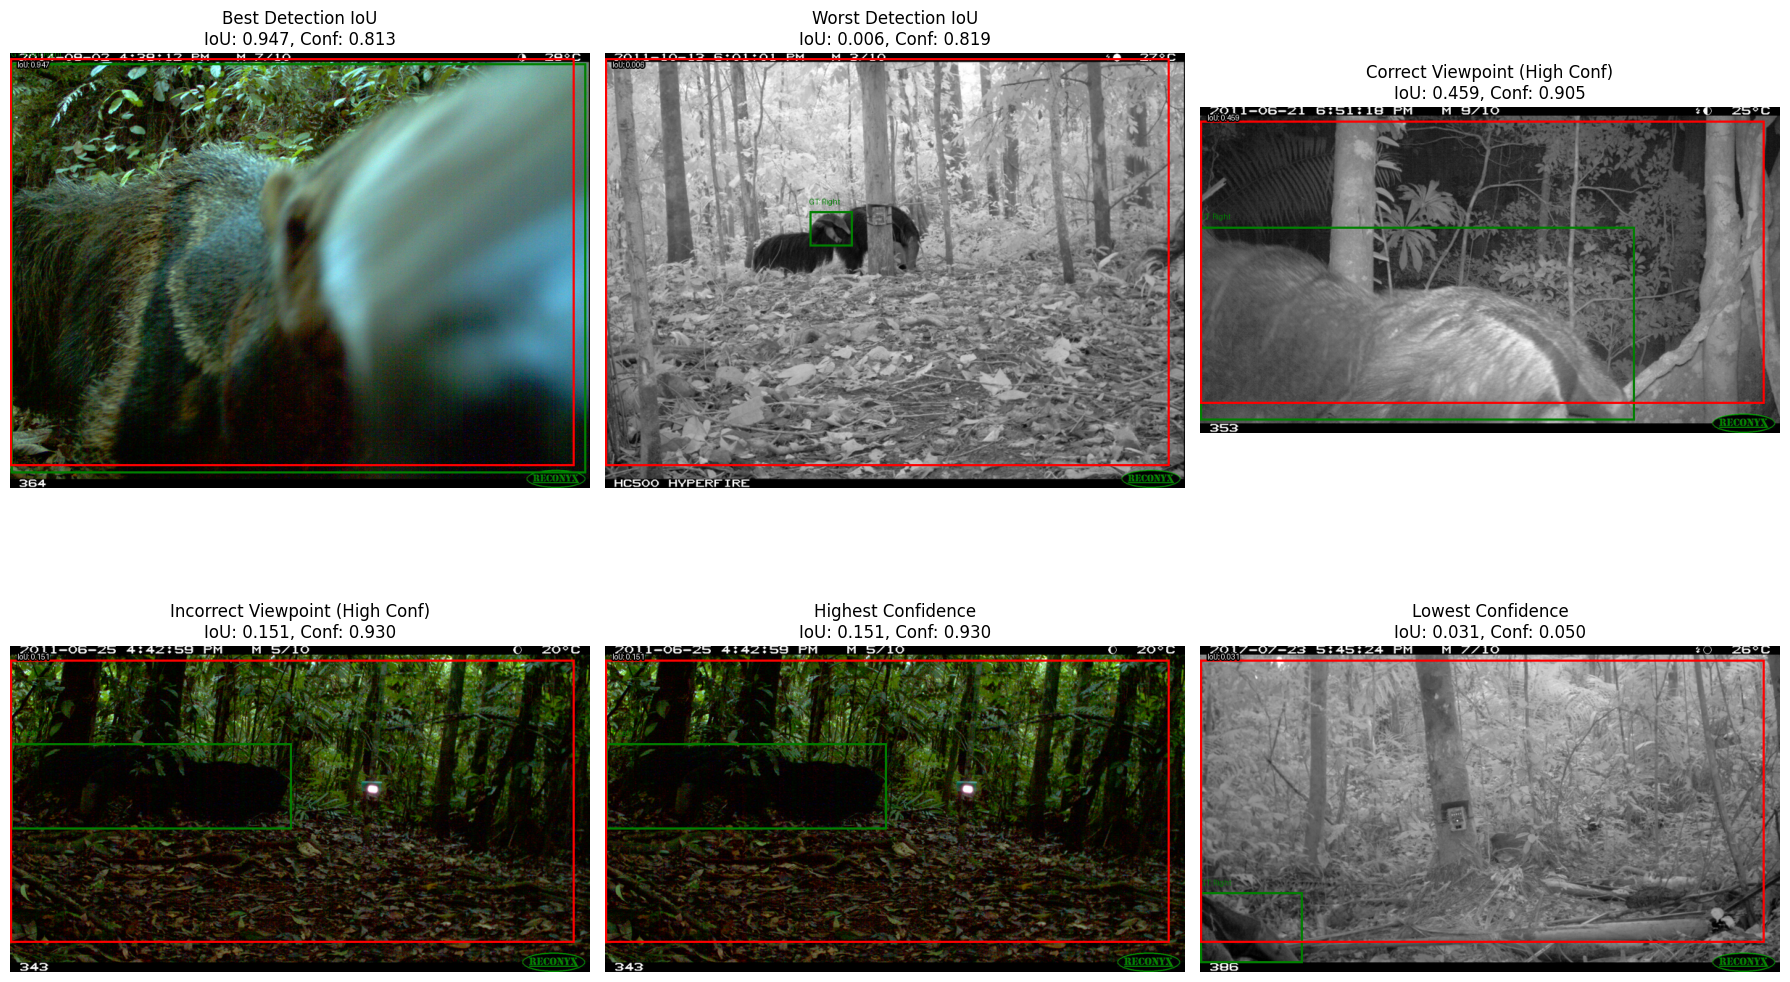


Legend:
  Green box: Ground truth bounding box
  Red box: Predicted bounding box
  GT: Ground truth viewpoint
  Pred: Predicted viewpoint (confidence)


In [6]:
def draw_bbox_on_image(image_path: str, gt_bbox: List[float], pred_bbox: List[int], 
                      gt_viewpoint: str, pred_viewpoint: str, confidence: float, 
                      iou: float, max_size: int = 800) -> Image.Image:
    """Draw bounding boxes and labels on image."""
    # Load and resize image if needed
    print(image_path)
    image = Image.open(image_path).convert('RGB')
    
    # Resize if too large
    if max(image.size) > max_size:
        scale = max_size / max(image.size)
        new_size = (int(image.width * scale), int(image.height * scale))
        image = image.resize(new_size, Image.Resampling.LANCZOS)
        
        # Scale bounding boxes
        gt_bbox = [coord * scale for coord in gt_bbox]
        if pred_bbox:
            pred_bbox = [int(coord * scale) for coord in pred_bbox]
    
    # Create drawing context
    draw = ImageDraw.Draw(image)
    
    # Draw ground truth bbox in green
    if gt_bbox:
        draw.rectangle(gt_bbox, outline='green', width=3)
        draw.text((gt_bbox[0], gt_bbox[1] - 20), f'GT: {gt_viewpoint}', fill='green')
    
    # Draw predicted bbox in red
    if pred_bbox:
        draw.rectangle(pred_bbox, outline='red', width=3)
        draw.text((pred_bbox[0], pred_bbox[1] - 40), 
                 f'Pred: {pred_viewpoint} ({confidence:.2f})', fill='red')
    
    # Add IoU text
    draw.text((10, 10), f'IoU: {iou:.3f}', fill='white', stroke_width=2, stroke_fill='black')
    
    return image

# Select interesting examples to visualize
def select_examples(results: List[Dict], n_examples: int = 6) -> List[Dict]:
    """Select diverse examples for visualization."""
    # Sort by different criteria and pick examples
    by_iou = sorted([r for r in results if r['detection_iou'] is not None], 
                    key=lambda x: x['detection_iou'], reverse=True)
    by_confidence = sorted([r for r in results if r['viewpoint_confidence'] > 0], 
                          key=lambda x: x['viewpoint_confidence'], reverse=True)
    
    # Select examples: best IoU, worst IoU, high confidence correct, low confidence, etc.
    examples = []
    
    # Best detection
    if by_iou:
        examples.append(('Best Detection IoU', by_iou[0]))
    
    # Worst detection
    if by_iou:
        examples.append(('Worst Detection IoU', by_iou[-1]))
    
    # Correct viewpoint predictions
    correct_preds = [r for r in results if r['gt_viewpoint'] == r['predicted_viewpoint'] 
                     and r['gt_viewpoint'] != 'Unknown']
    if correct_preds:
        best_correct = max(correct_preds, key=lambda x: x['viewpoint_confidence'])
        examples.append(('Correct Viewpoint (High Conf)', best_correct))
    
    # Incorrect viewpoint predictions
    incorrect_preds = [r for r in results if r['gt_viewpoint'] != r['predicted_viewpoint'] 
                       and r['gt_viewpoint'] != 'Unknown']
    if incorrect_preds:
        worst_incorrect = max(incorrect_preds, key=lambda x: x['viewpoint_confidence'])
        examples.append(('Incorrect Viewpoint (High Conf)', worst_incorrect))
    
    # High confidence examples
    if by_confidence:
        examples.append(('Highest Confidence', by_confidence[0]))
    
    # Low confidence examples
    if by_confidence:
        examples.append(('Lowest Confidence', by_confidence[-1]))
    
    return examples[:n_examples]

# Visualize selected examples
examples = select_examples(results, n_examples=6)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (title, result) in enumerate(examples):
    if i >= len(axes):
        break
    
    try:
        # Draw image with annotations
        annotated_image = draw_bbox_on_image(
            result['image_path'],
            result['gt_bbox'],
            result['predicted_bbox'],
            result['gt_viewpoint'],
            result['predicted_viewpoint'],
            result['viewpoint_confidence'],
            result['detection_iou']
        )
        
        # Display in subplot
        axes[i].imshow(annotated_image)
        axes[i].set_title(f'{title}\nIoU: {result["detection_iou"]:.3f}, Conf: {result["viewpoint_confidence"]:.3f}')
        axes[i].axis('off')
        
    except Exception as e:
        axes[i].text(0.5, 0.5, f'Error loading image:\n{str(e)}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(title)
        axes[i].axis('off')

# Hide unused subplots
for i in range(len(examples), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\nLegend:")
print("  Green box: Ground truth bounding box")
print("  Red box: Predicted bounding box")
print("  GT: Ground truth viewpoint")
print("  Pred: Predicted viewpoint (confidence)")

## Error Analysis

In [ ]:
# Analyze common error patterns
error_analysis = {
    'low_iou_high_conf': [],
    'high_iou_wrong_viewpoint': [],
    'low_conf_correct': [],
    'high_conf_incorrect': []
}

for result in results:
    if result['gt_viewpoint'] == 'Unknown':
        continue
        
    iou = result['detection_iou']
    conf = result['viewpoint_confidence']
    correct_viewpoint = result['gt_viewpoint'] == result['predicted_viewpoint']
    
    # Low IoU but high confidence
    if iou < 0.3 and conf > 0.7:
        error_analysis['low_iou_high_conf'].append(result)
    
    # High IoU but wrong viewpoint
    if iou > 0.5 and not correct_viewpoint:
        error_analysis['high_iou_wrong_viewpoint'].append(result)
    
    # Low confidence but correct
    if conf < 0.5 and correct_viewpoint:
        error_analysis['low_conf_correct'].append(result)
    
    # High confidence but incorrect
    if conf > 0.7 and not correct_viewpoint:
        error_analysis['high_conf_incorrect'].append(result)

print("Error Analysis:")
for error_type, cases in error_analysis.items():
    print(f"  {error_type.replace('_', ' ').title()}: {len(cases)} cases")
    if cases:
        # Show details of first few cases
        for i, case in enumerate(cases[:3]):
            print(f"    Example {i+1}: IoU={case['detection_iou']:.3f}, "
                  f"Conf={case['viewpoint_confidence']:.3f}, "
                  f"GT={case['gt_viewpoint']}, Pred={case['predicted_viewpoint']}")
        if len(cases) > 3:
            print(f"    ... and {len(cases) - 3} more")
    print()

## Performance Summary Dashboard

In [ ]:
# Create comprehensive performance dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Overall metrics
ax1 = fig.add_subplot(gs[0, 0])
metrics = ['Detection\nIoU', 'Viewpoint\nAccuracy', 'High IoU\nRate', 'Mean\nConfidence']
values = [stats['detection']['mean_iou'], 
          stats['viewpoint']['accuracy'],
          stats['detection']['high_iou_rate'],
          np.mean(confidences)]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
bars = ax1.bar(metrics, values, color=colors, alpha=0.7)
ax1.set_ylim(0, 1)
ax1.set_title('Overall Performance Metrics')
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{val:.3f}', ha='center', va='bottom')

# 2. IoU vs Confidence scatter
ax2 = fig.add_subplot(gs[0, 1])
scatter_ious = [r['detection_iou'] for r in results if r['detection_iou'] is not None and r['gt_viewpoint'] != 'Unknown']
scatter_confs = [r['viewpoint_confidence'] for r in results if r['detection_iou'] is not None and r['gt_viewpoint'] != 'Unknown']
correct_mask = [r['gt_viewpoint'] == r['predicted_viewpoint'] for r in results if r['detection_iou'] is not None and r['gt_viewpoint'] != 'Unknown']
colors = ['red' if not correct else 'green' for correct in correct_mask]
ax2.scatter(scatter_ious, scatter_confs, c=colors, alpha=0.6)
ax2.set_xlabel('Detection IoU')
ax2.set_ylabel('Viewpoint Confidence')
ax2.set_title('IoU vs Confidence\n(Green=Correct, Red=Incorrect)')
ax2.grid(True, alpha=0.3)

# 3. Per-class performance
ax3 = fig.add_subplot(gs[0, 2:])
class_names = list(viewpoint_accuracy.keys())
class_accs = [viewpoint_accuracy[name]['accuracy'] for name in class_names]
class_counts = [viewpoint_accuracy[name]['total'] for name in class_names]
bars = ax3.bar(range(len(class_names)), class_accs, color='lightblue', alpha=0.7)
ax3.set_xticks(range(len(class_names)))
ax3.set_xticklabels(class_names, rotation=45, ha='right')
ax3.set_ylabel('Accuracy')
ax3.set_title('Per-Class Viewpoint Accuracy')
ax3.set_ylim(0, 1)
for i, (bar, count) in enumerate(zip(bars, class_counts)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'n={count}', ha='center', va='bottom', fontsize=8)

# 4. Detection IoU distribution
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(ious, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax4.axvline(x=0.5, color='red', linestyle='--', label='IoU=0.5')
ax4.set_xlabel('Detection IoU')
ax4.set_ylabel('Count')
ax4.set_title('Detection IoU Distribution')
ax4.legend()

# 5. Confidence distribution
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(confidences, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
ax5.set_xlabel('Viewpoint Confidence')
ax5.set_ylabel('Count')
ax5.set_title('Confidence Distribution')

# 6. Success rate by confidence bins
ax6 = fig.add_subplot(gs[1, 2])
conf_bins = np.linspace(0, 1, 11)
bin_centers = (conf_bins[:-1] + conf_bins[1:]) / 2
success_rates = []
for i in range(len(conf_bins) - 1):
    bin_mask = [(conf_bins[i] <= conf < conf_bins[i+1]) for conf in confidences]
    bin_results = [r for r, mask in zip([r for r in results if r['gt_viewpoint'] != 'Unknown'], bin_mask) if mask]
    if bin_results:
        correct = sum(1 for r in bin_results if r['gt_viewpoint'] == r['predicted_viewpoint'])
        success_rates.append(correct / len(bin_results))
    else:
        success_rates.append(0)
ax6.bar(bin_centers, success_rates, width=0.08, alpha=0.7, color='lightgreen')
ax6.set_xlabel('Confidence Bin')
ax6.set_ylabel('Success Rate')
ax6.set_title('Success Rate vs Confidence')

# 7. Dataset statistics
ax7 = fig.add_subplot(gs[1, 3])
dataset_stats = [
    f"Total Images: {len(results)}",
    f"Mean IoU: {stats['detection']['mean_iou']:.3f}",
    f"Accuracy: {stats['viewpoint']['accuracy']:.3f}",
    f"High IoU Rate: {stats['detection']['high_iou_rate']:.3f}",
    f"Unique Viewpoints: {len(gt_unique)}",
    f"Mean Confidence: {np.mean(confidences):.3f}"
]
ax7.text(0.1, 0.9, '\n'.join(dataset_stats), transform=ax7.transAxes, 
         verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax7.set_xlim(0, 1)
ax7.set_ylim(0, 1)
ax7.set_title('Dataset Statistics')
ax7.axis('off')

# 8. Confusion matrix (simplified)
if stats['viewpoint']['confusion_matrix']:
    ax8 = fig.add_subplot(gs[2, :])
    conf_matrix = np.array(stats['viewpoint']['confusion_matrix'])
    class_labels = stats['viewpoint']['class_labels']
    im = ax8.imshow(conf_matrix, cmap='Blues')
    
    # Add text annotations
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            text = ax8.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")
    
    ax8.set_xticks(range(len(class_labels)))
    ax8.set_yticks(range(len(class_labels)))
    ax8.set_xticklabels(class_labels, rotation=45, ha='right')
    ax8.set_yticklabels(class_labels)
    ax8.set_xlabel('Predicted')
    ax8.set_ylabel('Ground Truth')
    ax8.set_title('Confusion Matrix')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax8, shrink=0.8)
    cbar.set_label('Count')

plt.suptitle('Dataset Evaluation Results Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nDashboard Complete! This provides a comprehensive view of:")
print("• Overall performance metrics")
print("• Detection vs classification performance correlation")
print("• Per-class accuracy breakdown")
print("• Distribution analysis")
print("• Confidence calibration")
print("• Detailed confusion matrix")

## Save Analysis Results

In [ ]:
# Create analysis summary for saving
analysis_summary = {
    'dataset_info': {
        'total_images': len(results),
        'unique_viewpoints': len(gt_unique),
        'viewpoint_distribution': dict(zip(gt_unique, gt_counts.tolist()))
    },
    'detection_performance': {
        'mean_iou': np.mean(ious),
        'median_iou': np.median(ious),
        'std_iou': np.std(ious),
        'high_iou_count': sum(1 for iou in ious if iou > 0.5),
        'high_iou_rate': sum(1 for iou in ious if iou > 0.5) / len(ious)
    },
    'viewpoint_performance': {
        'overall_accuracy': stats['viewpoint']['accuracy'],
        'mean_confidence': np.mean(confidences),
        'per_class_accuracy': viewpoint_accuracy
    },
    'error_patterns': {
        error_type: len(cases) for error_type, cases in error_analysis.items()
    }
}

# Save analysis summary
analysis_file = EVALUATION_DIR / 'notebook_analysis_summary.json'
with open(analysis_file, 'w') as f:
    json.dump(analysis_summary, f, indent=2, default=str)

print(f"Analysis summary saved to: {analysis_file}")
print("\nNotebook analysis complete!")
print("\nKey findings:")
print(f"• Detection performance: {np.mean(ious):.3f} mean IoU")
print(f"• Viewpoint accuracy: {stats['viewpoint']['accuracy']:.3f}")
print(f"• High confidence errors: {len(error_analysis['high_conf_incorrect'])} cases")
print(f"• Good detection, wrong viewpoint: {len(error_analysis['high_iou_wrong_viewpoint'])} cases")